In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

%load_ext autoreload
%autoreload 2
%aimport scqubits

time: 526 ms


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scqubits as scq

time: 5.24 ms


## Let us show what units the library currently assumes

In [3]:
scq.get_units()

'GHz'

time: 11.9 ms


## Let's define a few qubits and list the noise channels that they support

### Transmon (charge qubit parameters)

In [4]:
transmon = scq.Transmon(
    EJ=0.5,
    EC=12.0,
    ng=0.3,
    ncut=150
)
print(transmon)

TRANSMON
 ———— PARAMETERS ————
EJ	: 0.5
EC	: 12.0
ng	: 0.3
ncut	: 150
truncated_dim	: None
Hilbert space dimension	: 301
time: 10.7 ms


To see what noise channels are supported by this qubit we can call `supported_noise_channels()`

In [5]:
transmon.supported_noise_channels()

['tphi_1_over_f_cc',
 'tphi_1_over_f_ng',
 't1_capacitive_loss',
 't1_charge_impedance']

time: 10.1 ms


We can calculate a given decoherence time with an appropriate method. Take default parameters:

In [6]:
transmon.tphi_1_over_f_ng()

3.770056749342735

time: 13.6 ms


Or choose non-deafult paramters (eg. choose a downward transition from level 3 to 1, at T=0.100K):

In [7]:
transmon.t1_charge_impedance(i=3, j=1, T=0.100)

3013.2215669102766

time: 12.8 ms


scqubits can also approximate effective noise, which is calculated by considering total contributions from a variety of noise channels (that can be fine-tuned by the user). In the case of a depolarization noise, the effective (or combined) noise is obtained from 
\begin{equation}
\frac{1}{T_{1}^{\rm eff}} = \sum_k \frac{1}{T_{1}^{k}},
\end{equation}

where the sum runs over all the noise channels that the user wants included. By default those correpond to the the list returned by the `effective_noise_channels` method for each qubit. A differnt list of noise channels can be also provided as an argument. 

Simliarly, users can calculate effective depahsing, which includes contributions from both pure dephasing, as well as depolarization channels. Such a $T_{2}$ time is defined as

\begin{equation}
\frac{1}{T_{2}^{\rm eff}} = \sum_k \frac{1}{T_{\phi}^{k}} +  \frac{1}{2} \sum_j \frac{1}{T_{1}^{j}}, 
\end{equation}

where $k$ ($j$) run over the relevant pure dephasing (depolariztion) channels that can contribute to the effective noise. 

As an example, below we calculate the effective $T_1$ time

In [8]:
transmon.t1_effective()

2166838.6419612635

time: 12.8 ms


We can also plot how it varies as we change the charge offset

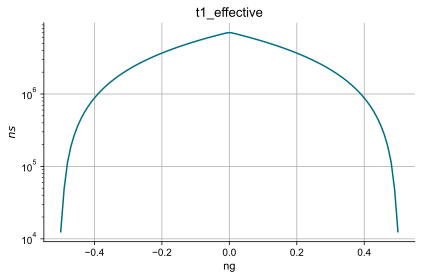

time: 531 ms


In [15]:
transmon.plot_t1_effective_vs_paramvals(param_name='ng', param_vals=np.linspace(-0.5, 0.5, 100));

Let us also calcualte the effective $T_2$, for a subspace definded by levels 2 and 3

In [16]:
transmon.t2_effective(common_noise_options=dict(i=3,j=2))

1.2562838641414429

time: 12.9 ms


We can also plot how this $T_2$ varies as we change the charge offset

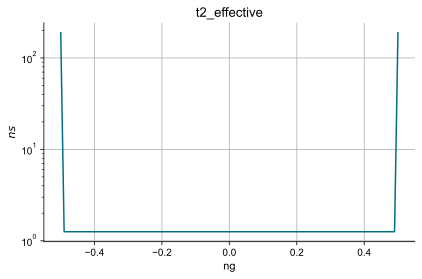

time: 539 ms


In [18]:
transmon.plot_t2_effective_vs_paramvals(param_name='ng', 
                                        param_vals=np.linspace(-0.5, 0.5, 100),
                                        common_noise_options=dict(i=3,j=2,total=False)
                                       );

We can also just plot the coherence due to all supported noise channels in individual plots, to see how they vary as we modify one of the qubit parameters, here the charge offset. The plotted/calcaulted data uses the currently set units to label plot axis. 

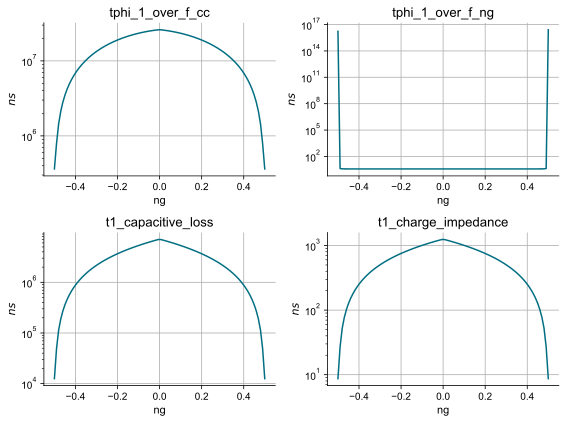

time: 1.05 s


In [19]:
transmon.plot_coherence_vs_paramvals(param_name='ng', param_vals=np.linspace(-0.5, 0.5, 100));

We can also easily scale the results, so that end up with time in units of $\mu s$

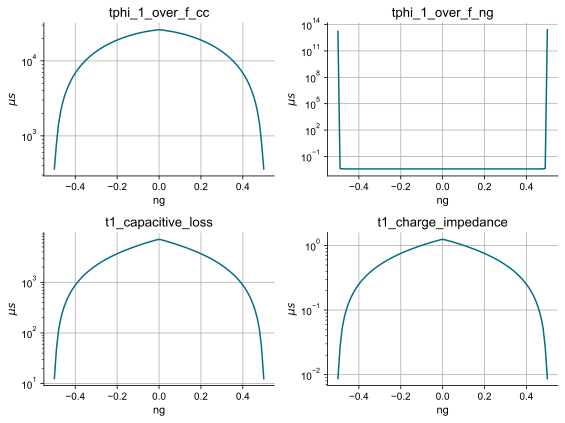

time: 1.05 s


In [20]:
transmon.plot_coherence_vs_paramvals(param_name='ng', 
                                     param_vals=np.linspace(-0.5, 0.5, 100), 
                                     scale=1e-3, 
                                     ylabel=r"$\mu s$");

Instead of looking at all the supported noise-channels, we can just consider a few selected ones. Furhermore, we can add extra customization to the plots. 

Text(0.5, 1.0, 'loss channel: t1_capacitive_loss')

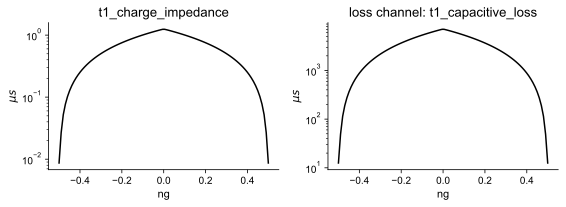

time: 706 ms


In [21]:
fig, ax=transmon.plot_coherence_vs_paramvals( 
                    param_name='ng', 
                    param_vals=np.linspace(-0.5, 0.5, 100), 
                    noise_channels=['t1_charge_impedance', 't1_capacitive_loss'], 
                    scale=1e-3, ylabel=r"$\mu s$", color='black', grid=False);

#customize the title
ax[1].set_title("loss channel: t1_capacitive_loss")

We can also pass specific options to calculations for ceratin noise channels. Below, as an example, where we choose a non-default temperateure for the ``t1_capacitive_loss`` channel calculation, and a transition between non-default (i.e. 0 and 1) energy levels. 

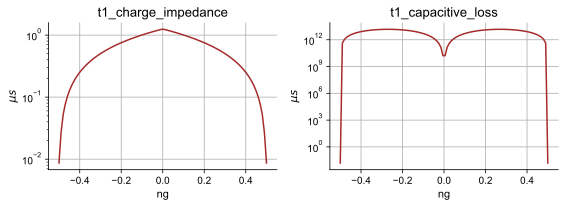

time: 694 ms


In [22]:
transmon.plot_coherence_vs_paramvals(param_name='ng',  
                                     param_vals=np.linspace(-0.5, 0.5, 100), 
                                     noise_channels=[
                                     't1_charge_impedance',
                                     ('t1_capacitive_loss', dict(T=0.045, i=3, j=2))
                                     ],  
                                     scale=1e-3, ylabel=r"$\mu s$", color='brown');

Can also plot just one channel, and provide standard plotting options directly to ``plot_noise()``

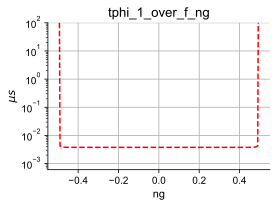

time: 598 ms


In [23]:
transmon.plot_coherence_vs_paramvals(
                    param_name='ng', 
                    param_vals=np.linspace(-0.5, 0.5, 100), 
                    noise_channels='tphi_1_over_f_ng', 
                    scale=1e-3, ylabel=r"$\mu s$", linestyle='--', color='red', ylim=(None, 1e2));

### Tunable Transmon

In [24]:
tune_tmon = scq.TunableTransmon(
    EJmax=20.0,
    EC=0.5,
    d=0.00,
    flux=0.0,
    ng=0.3,
    ncut=150
)
print(tune_tmon)
tune_tmon.supported_noise_channels()

TUNABLETRANSMON
 ———— PARAMETERS ————
EJmax	: 20.0
EC	: 0.5
d	: 0.0
flux	: 0.0
ng	: 0.3
ncut	: 150
truncated_dim	: None
Hilbert space dimension	: 301


['tphi_1_over_f_flux',
 'tphi_1_over_f_cc',
 'tphi_1_over_f_ng',
 't1_capacitive_loss',
 't1_flux_bias_line',
 't1_charge_impedance']

time: 11.8 ms


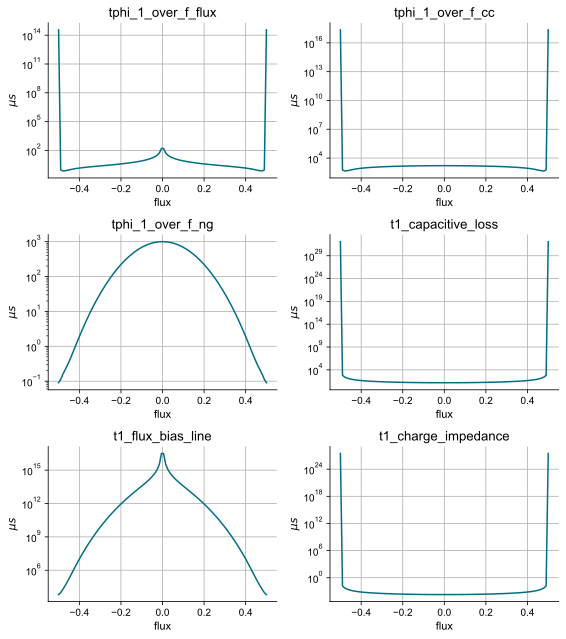

time: 1.27 s


In [25]:
tune_tmon.plot_coherence_vs_paramvals(param_name='flux', param_vals=np.linspace(-0.5, 0.5, 100), 
                                      scale=1e-3, ylabel=r"$\mu s$");

### Fluxonium

In [26]:
fluxonium = scq.Fluxonium(
    EJ=8.9,
    EC=2.5,
    EL=0.5,
    cutoff = 150,
    flux = 0.5
)
print(fluxonium)
fluxonium.supported_noise_channels()

FLUXONIUM
 ———— PARAMETERS ————
EJ	: 8.9
EC	: 2.5
EL	: 0.5
flux	: 0.5
cutoff	: 150
truncated_dim	: None
Hilbert space dimension	: 150


['tphi_1_over_f_cc',
 'tphi_1_over_f_flux',
 't1_flux_bias_line',
 't1_capacitive_loss',
 't1_inductive_loss',
 't1_charge_impedance']

time: 11.3 ms


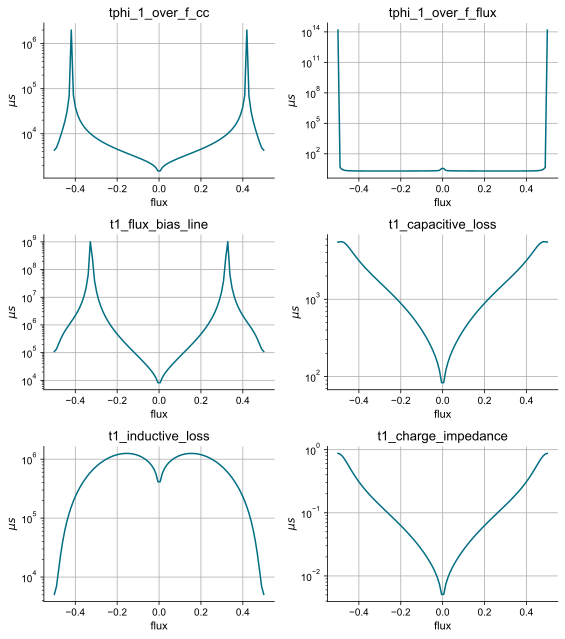

time: 4.86 s


In [27]:
fluxonium.plot_coherence_vs_paramvals(param_name='flux', 
                                      param_vals=np.linspace(-0.5, 0.5, 100), 
                                      scale=1e-3, 
                                      ylabel=r"$\mu s$");

### Flux Qubit

In [28]:
# parameters for the flux qubit
RATIO = 60.0
ALPHA = 0.8
flux_qubit = scq.FluxQubit(
    EJ1 = 1.0, 
    EJ2 = 1.0, 
    EJ3 = ALPHA*1.0, 
    ECJ1 = 1.0/RATIO, 
    ECJ2 = 1.0/RATIO, 
    ECJ3 = 1.0/ALPHA/RATIO, 
    ECg1 = 50.0/RATIO, 
    ECg2 = 50.0/RATIO, 
    ng1 = 0.0, 
    ng2 = 0.0, 
    flux = 0.4, 
    ncut = 10,
)
print(flux_qubit)
flux_qubit.supported_noise_channels()

FLUXQUBIT
 ———— PARAMETERS ————
EJ1	: 1.0
EJ2	: 1.0
EJ3	: 0.8
ECJ1	: 0.016666666666666666
ECJ2	: 0.016666666666666666
ECJ3	: 0.020833333333333332
ECg1	: 0.8333333333333334
ECg2	: 0.8333333333333334
ng1	: 0.0
ng2	: 0.0
flux	: 0.4
ncut	: 10
truncated_dim	: None
Hilbert space dimension	: 441


['tphi_1_over_f_cc1',
 'tphi_1_over_f_cc2',
 'tphi_1_over_f_cc3',
 'tphi_1_over_f_cc']

time: 7.68 ms


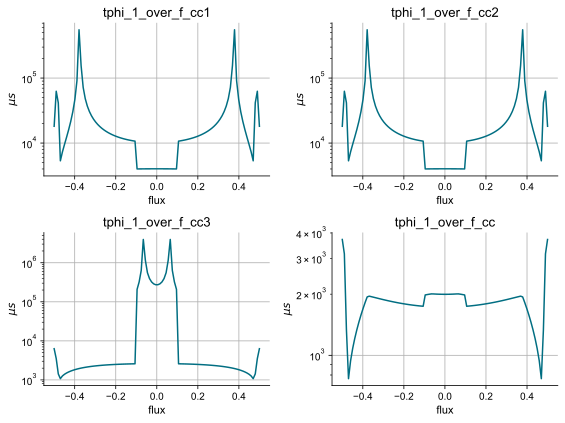

time: 5.02 s


In [29]:
flux_qubit.plot_coherence_vs_paramvals(param_name='flux', param_vals=np.linspace(-0.5, 0.5, 100), 
                                       scale=1e-3, ylabel=r"$\mu s$");

### ZeroPi

In [30]:
phi_grid = scq.Grid1d(-6*np.pi, 6*np.pi, 200)

EJ_CONST = 1/3.95  # note that EJ and ECJ are interrelated

zero_pi = scq.ZeroPi(
    grid = phi_grid,
    EJ   = EJ_CONST,
    EL   = 10.0**(-2),
    ECJ  = 1/(8.0*EJ_CONST),
    EC = None,
    ECS  = 10.0**(-3),
    ng   = 0.1,
    flux = 0.23,
    ncut = 30
)
print(zero_pi)
zero_pi.supported_noise_channels()

ZEROPI
 ———— PARAMETERS ————
EJ	: 0.2531645569620253
EL	: 0.01
ECJ	: 0.4937500000000001
EC	: 0.001002029426686961
dEJ	: 0
dCJ	: 0
ng	: 0.1
flux	: 0.23
grid	:     Grid1d ......
max_val	: 18.84955592153876
min_val	: -18.84955592153876
pt_count	: 200
ncut	: 30
truncated_dim	: None
Hilbert space dimension	: 12200


['tphi_1_over_f_cc',
 'tphi_1_over_f_flux',
 't1_flux_bias_line',
 't1_inductive_loss']

time: 7.51 ms


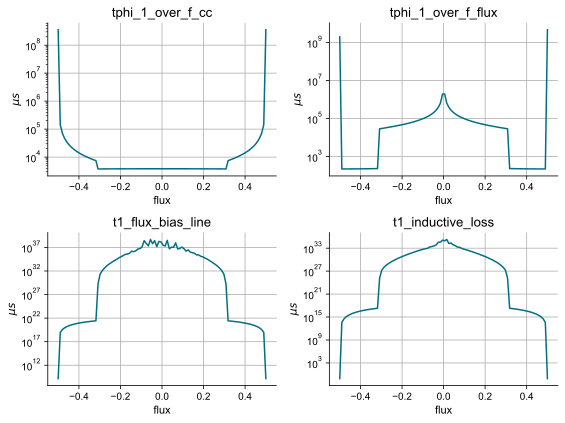

time: 35 s


In [31]:
zero_pi.plot_coherence_vs_paramvals(param_name='flux', param_vals=np.linspace(-0.5, 0.5, 100), 
                                    scale=1e-3, ylabel=r"$\mu s$");